# Testing that Attention is All You Need (To Build a Graph)

In [1]:
%load_ext autoreload
%autoreload 2

# System imports
import os
import sys
import yaml

# External imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns

import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch.utils.data import DataLoader, Dataset
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import TensorBoardLogger, WandbLogger
import scipy as sp
import wandb

import warnings

warnings.filterwarnings("ignore")
sys.path.append("../")
device = "cuda" if torch.cuda.is_available() else "cpu"

from models.submodels.interaction_gnn import InteractionGNN
from models.submodels.agnn import AGNN
from models.generation_utils import load_dataset

## Roadmap

1. Instantiate an AGNN model
2. Pull up an example graph
3. Run the graph through AGNN and plot the attention weights as color
4. For a particular node, backpropagate the attention weights for N graph iterations
5. Plot the relevance (as function of attention) of that node versus all other nodes for each graph iteration

## Model and Dataset

In [2]:
# load config
with open("toy_config.yaml", "r") as f:
    config = yaml.safe_load(f)

In [3]:
model = AGNN(config)

In [4]:
model.setup(stage="fit")
sample = model.trainset[0]

Setting up dataset


## Functions

In [5]:
def get_attention_weights(model, sample):
    with torch.no_grad():
        x = sample.x
        edges = torch.cat([sample.edge_index, sample.edge_index.flip(0)], dim=1)
        output, attention_weights = model(x, edges, log_attention=True)
        output = torch.sigmoid(output)
    return output, attention_weights

import matplotlib.cm as cm
def plot_graph_attention(x, edges, weights):
    weights = weights.numpy()
    plt.figure(figsize=(10, 10))
    weights = (weights - weights.min()) / (weights.max() - weights.min())
    for i in range(edges.shape[1]):
        plt.plot([x[edges[0, i], 0], x[edges[1, i], 0]], [x[edges[0, i], 1], x[edges[1, i], 1]], c=cm.inferno(1-weights[i][0]), alpha=weights[i][0])
    plt.scatter(x[:, 0], x[:, 1], s=20)
    plt.show()
    

## Inference Run

In [6]:
output, attention_weights = get_attention_weights(model, sample)

<AxesSubplot:ylabel='Count'>

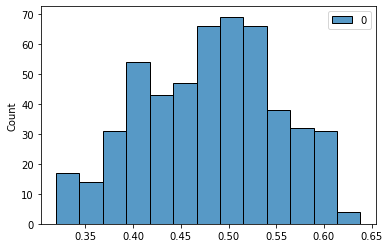

In [7]:
sns.histplot(output.numpy())

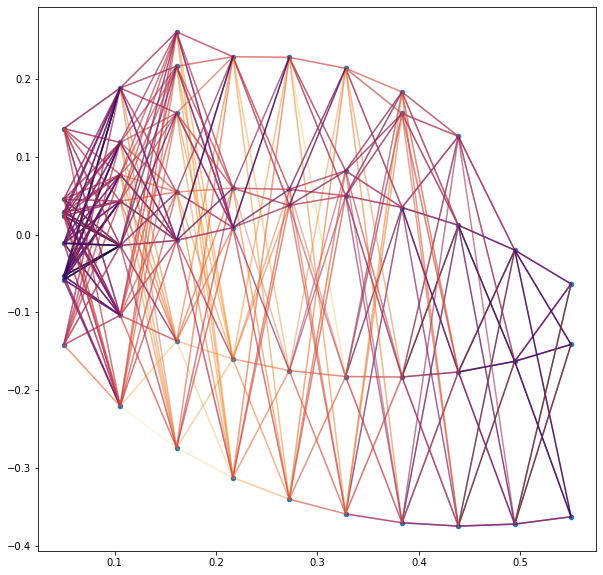

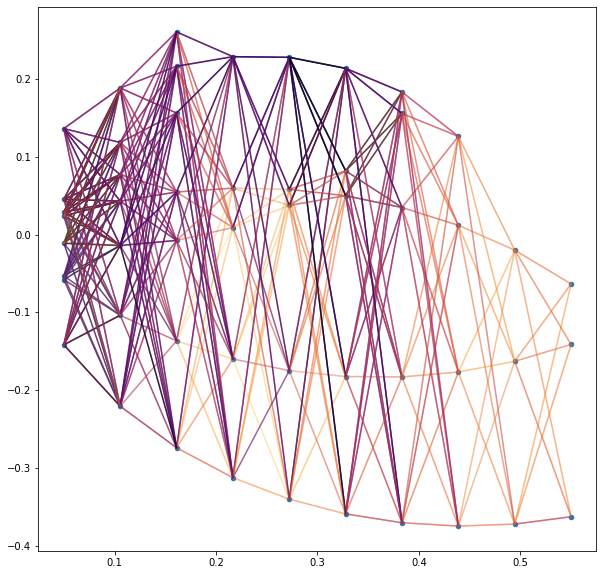

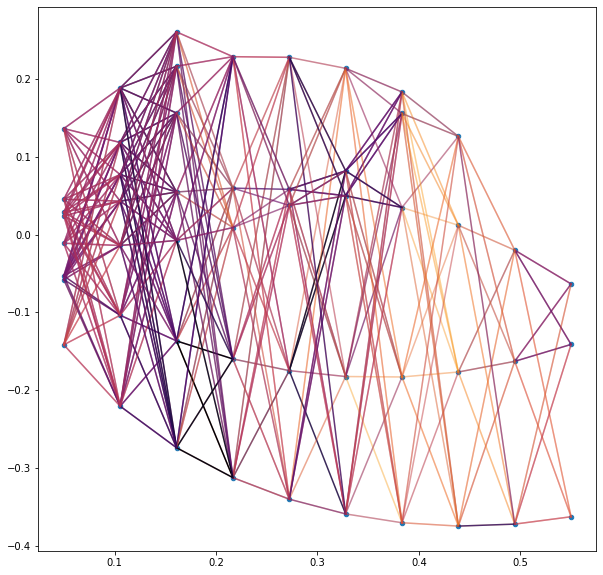

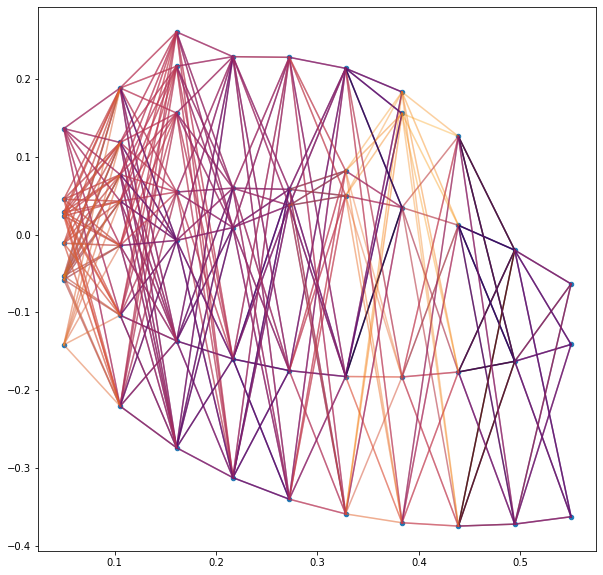

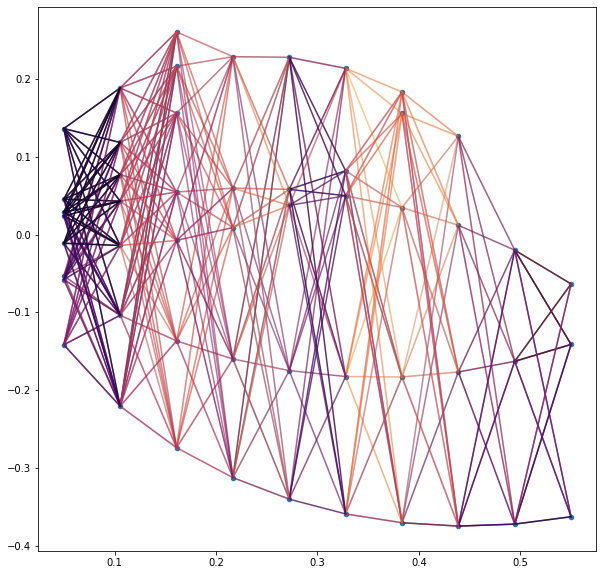

In [8]:
for attention_weight in attention_weights:
    edges = torch.cat([sample.edge_index, sample.edge_index.flip(0)], dim=1)
    plot_graph_attention(sample.x, edges, attention_weight)
    plt.pause(0.1)

plot_graph_attention(sample.x, edges, output)

## Apply Attention Propagation

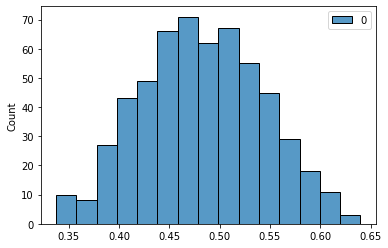

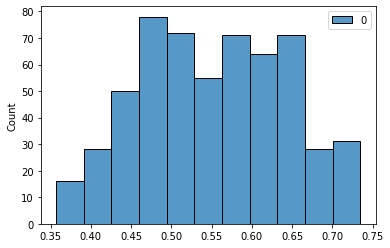

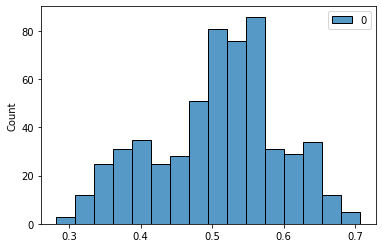

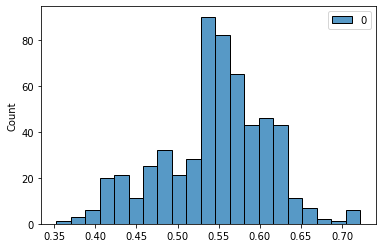

In [9]:
for i in range(len(attention_weights)):
    sns.histplot(attention_weights[i].numpy())
    plt.pause(0.1)

**Approach**

- Initially, just cast the weights to dense adjacency matrix
- Loop through backwards weights, multiplying by the previous attention weights
- Normalize the resulting matrix by summing over the rows
- Repeat for all graph iterations


In [10]:
adj_list = []

In [15]:
torch.arange(10).repeat(2, 1)

tensor([[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]])

In [16]:
for i in range(len(attention_weights)):
    # Turn edges to dense adjacency matrix with entries
    edges = torch.cat([sample.edge_index, sample.edge_index.flip(0)], dim=1)
    edges = torch.cat([edges, torch.arange(sample.x.shape[0]).repeat(2, 1)], dim=1)
    adj = torch.zeros(edges.max()+1, edges.max()+1)
    adj[edges[0, :], edges[1, :]] = attention_weights[i].squeeze()
    adj_list.append(adj)

In [22]:
adj_list[-1]

tensor([[0.5820, 0.0000, 0.5503,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.5846, 0.5636,  ..., 0.0000, 0.0000, 0.0000],
        [0.4228, 0.4203, 0.4277,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.5783, 0.6326, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.4678, 0.4916, 0.4277],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.4677, 0.3853]])

In [23]:
adj_list[-2]

tensor([[0.5360, 0.0000, 0.4255,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.5481, 0.4209,  ..., 0.0000, 0.0000, 0.0000],
        [0.6153, 0.6097, 0.6702,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.5025, 0.6278, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.5025, 0.5611, 0.5598],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.6132, 0.5436]])

In [32]:
mult_adj_list = []
mult_adj_list.append(adj_list[-1])
# Matrix multiply and normalize along rows
for i in range(-2, -len(adj_list)-1, -1):
    mult_adj = torch.matmul(adj_list[i], mult_adj_list[-1])
    mult_adj = F.normalize(mult_adj, p=1, dim=0)
    mult_adj_list.append(mult_adj)

In [34]:
mult_adj_list[-1][:, -2].sum()

tensor(1.0000)

In [35]:
def plot_node_relevance(node_of_interest, adj_matrix):
    weights = adj_matrix[:, node_of_interest]
    weights = (weights - weights.min()) / (weights.max() - weights.min())
    weights = weights.numpy()
    plt.figure(figsize=(10, 10))
    plt.scatter(sample.x[:, 0], sample.x[:, 1], s=20, c=cm.inferno(weights))
    plt.scatter(sample.x[node_of_interest, 0], sample.x[node_of_interest, 1], s=100, c="red", marker="*")

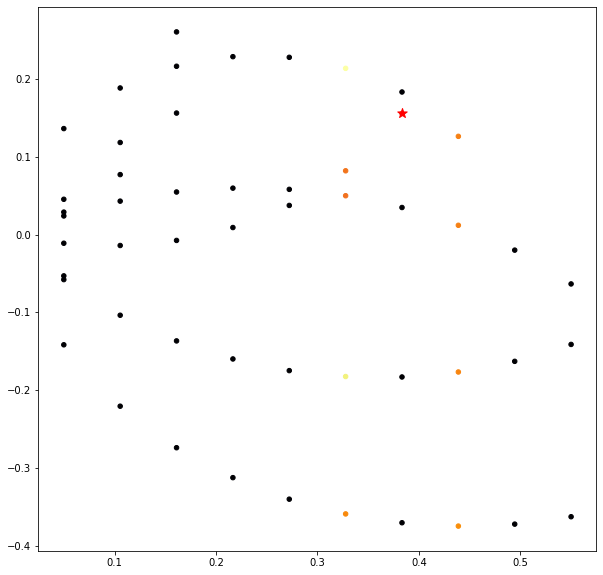

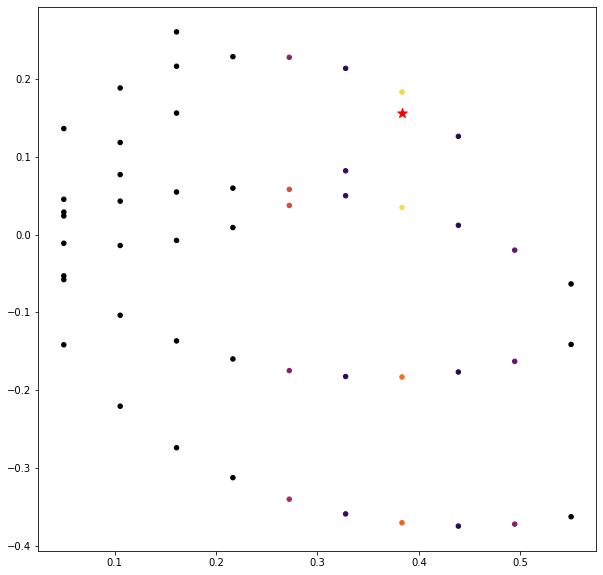

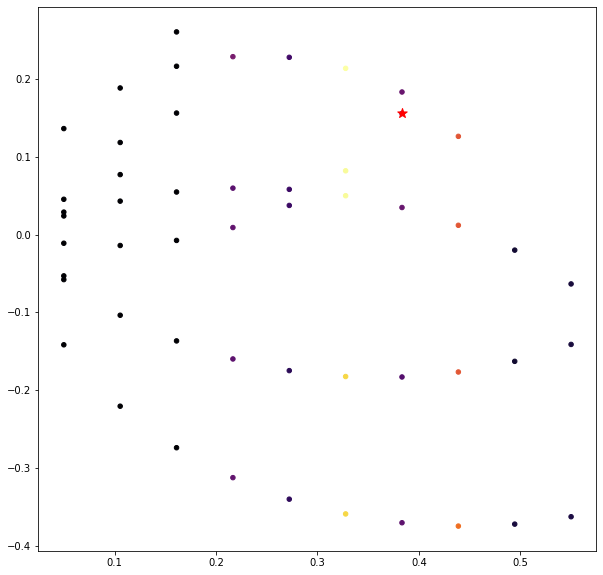

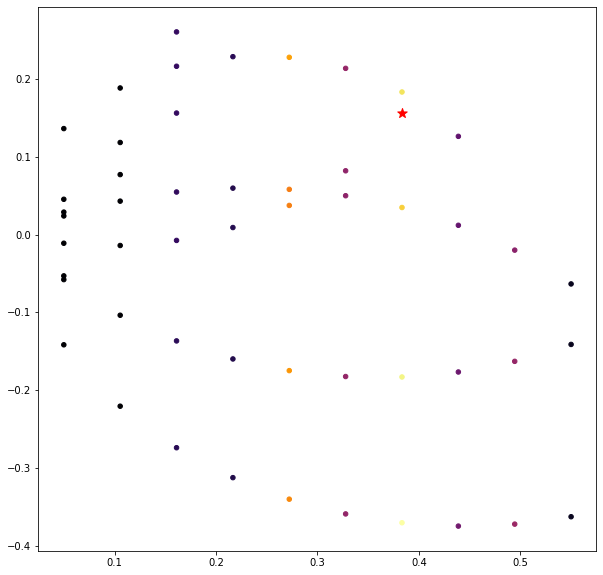

In [36]:
for adj_matrix in mult_adj_list:
    plot_node_relevance(-1, adj_matrix)
    plt.pause(0.1)